In [2]:
import requests
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime
import os 
import sys
import matplotlib.pyplot as plt

MAIN_DIR = 'Speed_Skating_results'

In [3]:
class Scrape_Speed_Skating:
    def __init__(self):
        self.dataframe = None
        self.pages_dict = {}
    
    def Create_Table(self,tournament_no,season):  
        self.tournament_code = tournament_no
        self.season = season
        df_list = []
        self.__Retrieve_Page_Links__()
        for page in tqdm(self.pages_dict[self.tournament_title]): 
            df_list.append(self.__Read_Page__(page))
        self.dataframe = pd.concat(df_list,ignore_index=True)
        self.Table_to_CSV()
        
    def Table_to_CSV(self):
        self.dataframe.to_csv(f'Speed_Skating_results/{season}_speed_skating_{self.tournament_title}_{self.tournament_code}.csv', index=False)  

    def __Read_Page__(self,page):
        result = requests.get(f'https://speedskatingresults.com/index.php?p=3&e={self.tournament_code}&r={page}')
        self.bs = BeautifulSoup(result.content, 'html.parser')

        return self.__Web_table_to_pandas__()
    
    def __Retrieve_Page_Links__(self):
        result = requests.get(f'https://speedskatingresults.com/index.php?p=2&e={self.tournament_code}')
        main_page = BeautifulSoup(result.content, 'html.parser')
        self.tournament_title = main_page.find('main').find('h2').find('a').text.strip()
        tables = main_page.find('main').find_all('table')
        link_list = []
        page_no_list = []
        for table in tables:
            daily_distances_list = table.find_all('td')
            for dist in daily_distances_list:
                if 'Mass' in dist.find('a').text or 'Team' in dist.find('a').text or 'Relay' in dist.find('a').text:
                    pass
                else:
                    link_list.append(dist.find('a').get('href'))
        length_list = self.__length_aux__(link_list)
        for i,item in enumerate(link_list):
            if length_list[i] == 0:
                page_no_list.append(int(item[-1]))
            else:
                page_no_list.append(int(item[-2:]))
        
        self.pages_dict[self.tournament_title] = page_no_list
    
    def __Convert_to_int_seconds__(self, time_string):
        if time_string in ['WDR','DNS', 'DQ', 'DNF']:
            return None
        if len(time_string.split('.')) == 2:
                minute = int(time_string.split('.')[0])
                first_split = time_string.split('.')[1]
        else:
            minute = 0
            first_split = time_string.split('.')[0]
        second = int(first_split.split(',')[0])
        centi = int(first_split.split(',')[1].split('(')[0])
        if len(first_split.split(',')[1].split('(')) == 2:            
            milli = int(first_split.split(',')[1].split('(')[1].split(')')[0])
        else: 
            milli = 0
        return minute*60+second+centi/100+milli/1000
    
    def __Web_table_to_pandas__(self):
        index = self.bs.find('table').find('thead').find_all('th')

        main_page = self.bs.find('main')

        location_date_list = main_page.find_all('h2')[0].text.strip().split()
        location = ' '.join(location_date_list[0:2])

        tournament_list  = main_page.find('h1').text.split()
        tournament = ' '.join(tournament_list)

        distance = main_page.find_all('h2')[-1].text.split()[0]

        sex = main_page.find_all('h2')[-1].text.split()[1]

        division = main_page.find_all('h2')[-1].text.split()[-4]

        date_list = main_page.find_all('h2')[-1].text.split()[-3:]
        date_string = ' '.join(date_list)
        date = datetime.strptime(date_string, "%d %B %Y")

        rows = self.bs.find('table').find_all('tr')

        name_list = []
        country_list = []
        time_list = []
        tis_list = []
        for row in rows:
            columns = row.find_all('td')
            if len(columns) != 0:
                name_list.append(' '.join(columns[1].text.split()[0:2]))
                country_list.append(columns[4].text)
                time = columns[5].text
                time_list.append(columns[5].text)        
                time_in_seconds = self.__Convert_to_int_seconds__(time)
                tis_list.append(time_in_seconds)
        n = len(name_list)
        return pd.DataFrame(data={'name' : name_list, 'country': country_list, 
                                'time (string)' : time_list, 'time (int)' : tis_list, 
                                'M/W' : [sex]*n, 'Distance' : [distance]*n, 'division':[division]*n,
                                  'date' : pd.to_datetime([date]*n), 
                                  'Location' : [location]*n,'tournament_type' : [tournament]*n})
    
    def __length_aux__(self, list):
        length_list = [len(item) for item in list]

        return [item - min(length_list) for item in length_list]

    
    
    

In [4]:
def Find_World_Cup_Years(year):
    result = requests.get(f'https://speedskatingresults.com/index.php?p=12&y={year}&c=2')
    bs = BeautifulSoup(result.content, 'html.parser')
    rows = bs.find('table').find_all('td')
    href_list = []
    for row in rows:
        if row.find('a') != None:
            if 'Junior' in row.find('a').text.strip() or 'Neo-Senior' in row.find('a').text.strip():
                pass
            elif 'World Cup' in row.find('a').text.strip():
                href_list.append(row.find('a').get('href'))

    return [int(item[-(len(item)-16):]) for item in href_list]

## Scrape World Cup for seasons 2007 - 2023

In [ ]:
for season in range(2007,2024):
    SSS = Scrape_Speed_Skating()
    tournament_list = Find_World_Cup_Years(season)
    for tournament in tournament_list:
        SSS.Create_Table(tournament,season)

## Reading files

In [37]:
class Show_Speed_Skating:
    def __init__(self,main_dir):
        self.main_dir = main_dir
        skating_dir = os.listdir(main_dir)
        df_list = []
        for file in skating_dir:
            df_list.append(pd.read_csv(MAIN_DIR + '/' + file))
        self.df_total = pd.concat(df_list,ignore_index=True)
        self.df_total['date'] = pd.to_datetime(self.df_total['date'])
        self.df_total['year'] = pd.DatetimeIndex(self.df_total['date']).year
        self.df_total['month'] = pd.DatetimeIndex(self.df_total['date']).month
        self.df_total['day'] = pd.DatetimeIndex(self.df_total['date']).day
        
    def time_progress(self,distance,sex,stat_list):
        '''
        distance: str - choose from ['500m','1000m','1500m','3000m','5000m','10000m']
        sex: str - choose from ['Men', 'Women']
        stat: list - add to list ['Avg', 'Best', 'Top3','Top5','Top10']
        '''
        self.df_atp = self.df_total[(self.df_total['Distance']==distance) & (self.df_total['M/W']==sex) & 
                                ((self.df_total['division']=='A') | (self.df_total['division']==sex))]
        avg_list = []
        best_list = []
        top3_list = []
        top5_list = []
        top10_list = []
        
        plt.figure(figsize=(10,6))
        
        if 'Avg' in stat_list:
            for year in range(2007,2025):
                avg_list.append(round(self.df_atp[self.df_atp['year']==year]['time (int)'].mean(),3))
            plt.plot(range(2007,2025),avg_list,label='average times')
        if 'Best' in stat_list:
            for year in range(2007,2025):
                best_list.append(round(self.df_atp[self.df_atp['year']==year]['time (int)'].min(),3))
            plt.plot(range(2007,2025),best_list,label='best times')
        if 'Top3' in stat_list:
            for year in range(2007,2025):
                top3_list.append(round(self.df_atp[self.df_atp['year']==year].nsmallest(3,'time (int)')['time (int)'].mean(),3))
            plt.plot(range(2007,2025),top3_list,label='top 3 best times')
        if 'Top5' in stat_list:
            for year in range(2007,2025):
                top5_list.append(round(self.df_atp[self.df_atp['year']==year].nsmallest(5,'time (int)')['time (int)'].mean(),3))
            plt.plot(range(2007,2025),top5_list,label='top 5 best times')
        if 'Top10' in stat_list:
            for year in range(2007,2025):
                top10_list.append(round(self.df_atp[self.df_atp['year']==year].nsmallest(10,'time (int)')['time (int)'].mean(),3))
            plt.plot(range(2007,2025),top10_list, label='top 10 best times')
        
        plt.xticks(range(2007,2025))
        plt.title(f'Time stats per year for {distance} {sex} speed skating (World Cup)')
        plt.legend()
        plt.show() 
        
Show_SS = Show_Speed_Skating(MAIN_DIR)

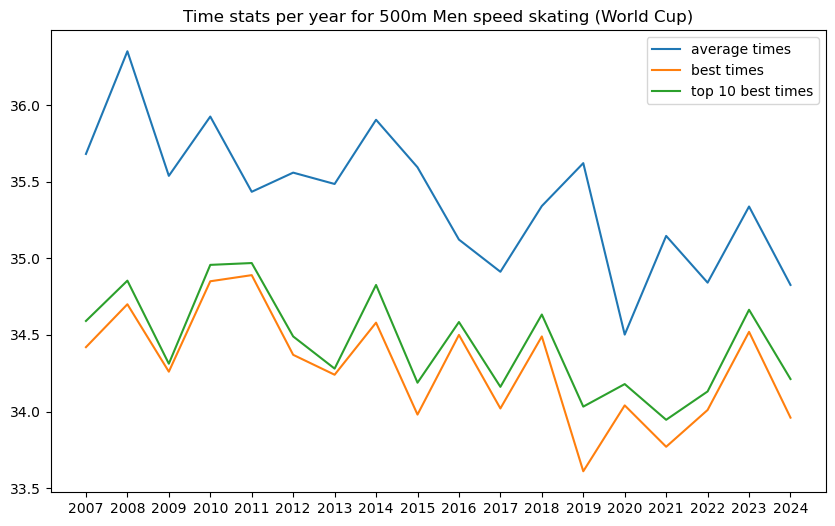

In [42]:
Show_SS.time_progress('500m', 'Men',['Avg','Best','Top10'])